In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using backend: pytorch


In [2]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [3]:
import numpy as np
g = dataset[0]
g
# len(g.ndata['feat'])

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

In [4]:
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
{'train_mask': tensor([False, False, False,  ..., False, False, False]), 'label': tensor([4, 4, 4,  ..., 4, 3, 3]), 'val_mask': tensor([False, False,  True,  ..., False, False, False]), 'test_mask': tensor([ True,  True, False,  ..., False, False, False]), 'feat': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])}
Edge features
{}


In [5]:
g.ndata['feat'].shape

torch.Size([2708, 1433])

In [6]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, num_classes):
        super(GCN, self).__init__()
#         self.conv1 = nn.Conv2d(in_feats, 128, (1,3))
        
        self.conv1 = GraphConv(in_feats, 64)
        self.conv2 = GraphConv(64, num_classes)

#         self.conv3 = GraphConv(16, num_classes)
#         self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.LeakyReLU(0.1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(num_classes)
#         self.batchnorm3 = nn.BatchNorm1d(num_classes)
        self.softmax = nn.Softmax(dim=1)
        
#         self.fc1 = nn.linear()
    def forward(self, g, x):
        
        x = self.conv1(g, x)
#         x = self.batchnorm1(x)
        x = self.relu(x)
#         x = self.dropout(x)
        
        x = self.conv2(g, x)
#         x = self.batchnorm2(x)
        x = self.relu(x)
#         x = self.dropout(x)

#         x = self.conv3(g, x)
# #         x = self.batchnorm2(x)
#         x = self.relu(x)
# #         x = self.dropout(x)
        
#         x = self.fc3(x)
#         x = self.batchnorm3(x)
#         x = self.relu(x)
        
        x = self.softmax(x)
        
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(g.ndata['feat'].shape[1], dataset.num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

GCN(
  (conv1): GraphConv(in=1433, out=64, normalization=both, activation=None)
  (conv2): GraphConv(in=64, out=7, normalization=both, activation=None)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)

Training the GCN
----------------

Training this GCN is similar to training other PyTorch neural networks.




In [31]:
# def train(g, model):
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
best_val_acc = 0
best_test_acc = 0
g = g.to(device)
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

loss_value = []
acc_value = []
for e in range(300):
    # Forward
    logits = model(g, features)
    
    # Compute prediction
    pred = logits.argmax(1) #機率最大的類別index
    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    val = (pred[val_mask] == labels[val_mask])
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_value.append(loss.cpu().detach().numpy())
    acc_value.append(val_acc.cpu().detach().numpy())

#     if e % 5 == 0:
    print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
            e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

In epoch 0, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 1, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 2, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 3, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 4, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 5, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 6, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 7, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 8, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 9, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 10, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In epoch 11, loss: 1.166, val acc: 0.780 (best 0.780), test acc: 0.767 (best 0.767)
In

In epoch 103, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 104, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 105, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 106, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 107, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 108, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 109, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 110, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 111, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 112, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 113, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.767 (best 0.767)
In epoch 114, loss: 1.166, val acc: 0.782 (best 0.782), test acc:

In epoch 203, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 204, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 205, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 206, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 207, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 208, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 209, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 210, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 211, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 212, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 213, loss: 1.166, val acc: 0.782 (best 0.782), test acc: 0.766 (best 0.767)
In epoch 214, loss: 1.166, val acc: 0.782 (best 0.782), test acc:

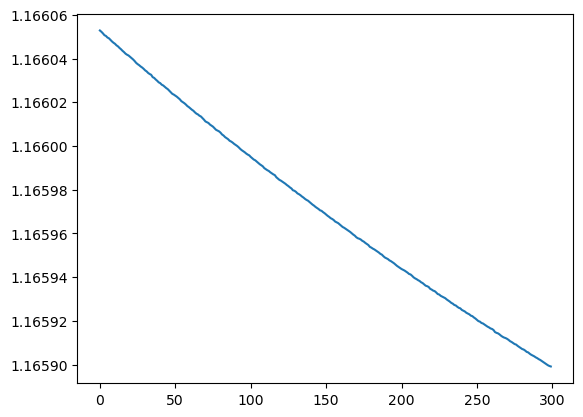

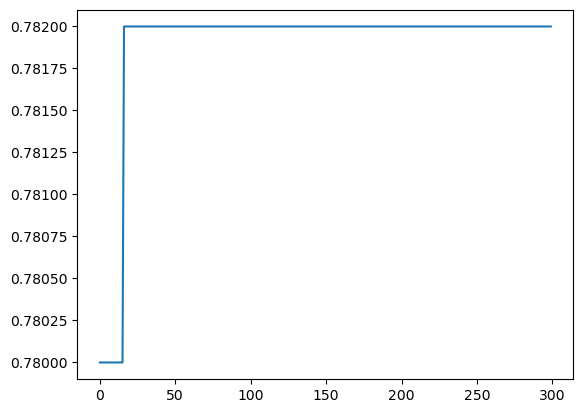

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_value)
plt.show()
plt.plot(acc_value)
plt.show()